In [1]:
!pip install delta-spark==2.4.0 pulsar-client[avro]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 12.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 14.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 10.5 MB/s eta 0:00:00


In [1]:
from pyspark.conf import SparkConf
from pyspark.context import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SparkSession
import random 
from random import randint
from pyspark.sql import functions as f
from pyspark.sql.types import StringType
from delta.tables import DeltaTable
import pulsar
from pulsar import schema as pulsar_schema
from fastavro.schema import parse_schema

In [2]:
spark_conf = (
    SparkConf()
        .setAppName("DemoPipeline")
        .set("spark.jars.packages", 'org.apache.hadoop:hadoop-client:3.3.4'
             ',org.apache.hadoop:hadoop-aws:3.3.4'
             ',io.delta:delta-core_2.12:2.4.0'
             ',io.streamnative.connectors:pulsar-spark-connector_2.12:3.4.0.3'
            )
        .set("spark.driver.memory", "6g")
        .set("spark.hadoop.fs.s3a.endpoint", "minio:9000")
        .set("spark.hadoop.fs.s3a.access.key", "pPZWyzFK4auwPEHCrmuw")
        .set("spark.hadoop.fs.s3a.secret.key", "M8i0y8Ef9jDntigOXfTXhnqoCpZ5v7NVHwC7NhRd")
        .set("spark.hadoop.fs.s3a.path.style.access", "true")
        .set("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
        .set('spark.hadoop.fs.s3a.aws.credentials.provider', 'org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider')
        .set("spark.hadoop.fs.s3a.connection.ssl.enabled", "false")

        .set("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") 
        .set("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
    )

sc = SparkContext.getOrCreate(spark_conf)
spark = SparkSession(sc)

In [3]:
print(f"Hadoop version = {spark._jvm.org.apache.hadoop.util.VersionInfo.getVersion()}")
print(f"Spark version = {spark.version}")

Hadoop version = 3.3.4
Spark version = 3.4.0


In [4]:
!rm -R ./checkpoint*

### Data generation

In [3]:
import datetime

product = []  #product, price 
sales = []  #user_id, product, volume, amount, date
users = [] #user_id, location

for _ in range(50):
    product_name = f'product_{_}'
    product_price = random.randint(2, 50)
    product.append((product_name, product_price))

for _ in range(1000):
    user_id = _
    user_localization = f'localization_{random.randint(100,200)}'
    users.append((user_id, user_localization))
    

for i in range(random.randint(50_000, 100_000)):
    date = datetime.datetime(2018, 6, random.randint(1,4)).strftime("%x")
    buy = random.choice(product)
    volume = random.randint(1,5)
    sales.append(
        (random.choice(users)[0],
         buy[0],
         volume,
         volume*buy[1],
         date
                    )
           )

In [4]:
users_df = spark.createDataFrame(users, ['user_id', 'localization'])
product_df = spark.createDataFrame(product, ['product_name', 'price'])
sales_df = spark.createDataFrame(sales, ['user_id', 'product_name', 'volume', 'amount', 'date'])

In [5]:
users_df.write.format('parquet').mode('overwrite').save('s3a://stream-buck/users')
product_df.write.format('parquet').mode('overwrite').save('s3a://stream-buck/products')
sales_df.write.format('parquet').mode('overwrite').save('s3a://stream-buck/sales')

In [5]:
refer = spark.read.load('s3a://stream-buck/sales')
df = spark.readStream.format('parquet').schema(refer.schema).load('s3a://stream-buck/sales')

In [6]:
refer.printSchema()

root
 |-- user_id: long (nullable = true)
 |-- product_name: string (nullable = true)
 |-- volume: long (nullable = true)
 |-- amount: long (nullable = true)
 |-- date: string (nullable = true)



In [7]:
df.printSchema()

root
 |-- user_id: long (nullable = true)
 |-- product_name: string (nullable = true)
 |-- volume: long (nullable = true)
 |-- amount: long (nullable = true)
 |-- date: string (nullable = true)



### writing data to Pulsar

In [8]:
avro_schema = parse_schema(
{
  "type" : "record",
  "name" : "salestransaction",
  "fields" : [ {
    "name" : "user_id",
    "type" : [ "long", "null" ]
  }, {
    "name" : "product_name",
    "type" : [ "string", "null" ]
  }, {
    "name" : "volume",
    "type" : [ "long", "null" ]
  },{
    "name" : "amount",
    "type" : [ "long", "null" ]
  }, {
    "name" : "date",
    "type" : [ "string", "null" ]
  } ]
} 
)
    

# client = pulsar.Client("pulsar://172.19.0.2:6650")
client = pulsar.Client("pulsar://172.19.0.2:6650")
producer = client.create_producer(
                    topic="persistent://public/default/test_one",
                    schema=pulsar_schema.AvroSchema(None, schema_definition=avro_schema)
)

In [9]:
df_writer = df.writeStream \
  .format("pulsar") \
  .option("service.url", "pulsar://172.19.0.2:6650") \
  .option("admin.url", "pulsar://172.19.0.2:8080") \
  .option("topic", "persistent://public/default/test_one") \
  .option("pulsar.client.tlsAllowInsecureConnection","true") \
  .option("pulsar.client.tlsHostnameVerificationenable","false") \
  .option("checkpointLocation", './checkpoints-pulsar1') \
    .start()


In [10]:
df_writer.status

{'message': 'Processing new data',
 'isDataAvailable': True,
 'isTriggerActive': True}

In [12]:
df_writer.status

{'message': 'Getting offsets from FileStreamSource[s3a://stream-buck/sales]',
 'isDataAvailable': False,
 'isTriggerActive': True}

In [13]:
df_writer.status

{'message': 'Waiting for data to arrive',
 'isDataAvailable': False,
 'isTriggerActive': False}

In [14]:
df_writer.stop()

In [15]:
df_writer.exception()

### reading data from Pulsar

In [16]:
pulsar_income_df = spark \
  .readStream \
  .format("pulsar") \
  .option("service.url", "pulsar://172.19.0.2:6650") \
  .option("admin.url", "pulsar://172.19.0.2:8080") \
  .option("topic", "persistent://public/default/test_one") \
  .option("pulsar.client.tlsAllowInsecureConnection","true") \
  .option("pulsar.client.tlsHostnameVerificationenable","false") \
  .option("checkpointLocation", './checkpoints-pulsar2') \
  .load()

In [17]:
pulsar_income_df.printSchema()

root
 |-- user_id: long (nullable = true)
 |-- product_name: string (nullable = true)
 |-- volume: long (nullable = true)
 |-- amount: long (nullable = true)
 |-- date: string (nullable = true)
 |-- __key: binary (nullable = true)
 |-- __topic: string (nullable = true)
 |-- __messageId: binary (nullable = true)
 |-- __publishTime: timestamp (nullable = true)
 |-- __eventTime: timestamp (nullable = true)
 |-- __messageProperties: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)



In [18]:
pulsar_income_df.writeStream.format("console").start()

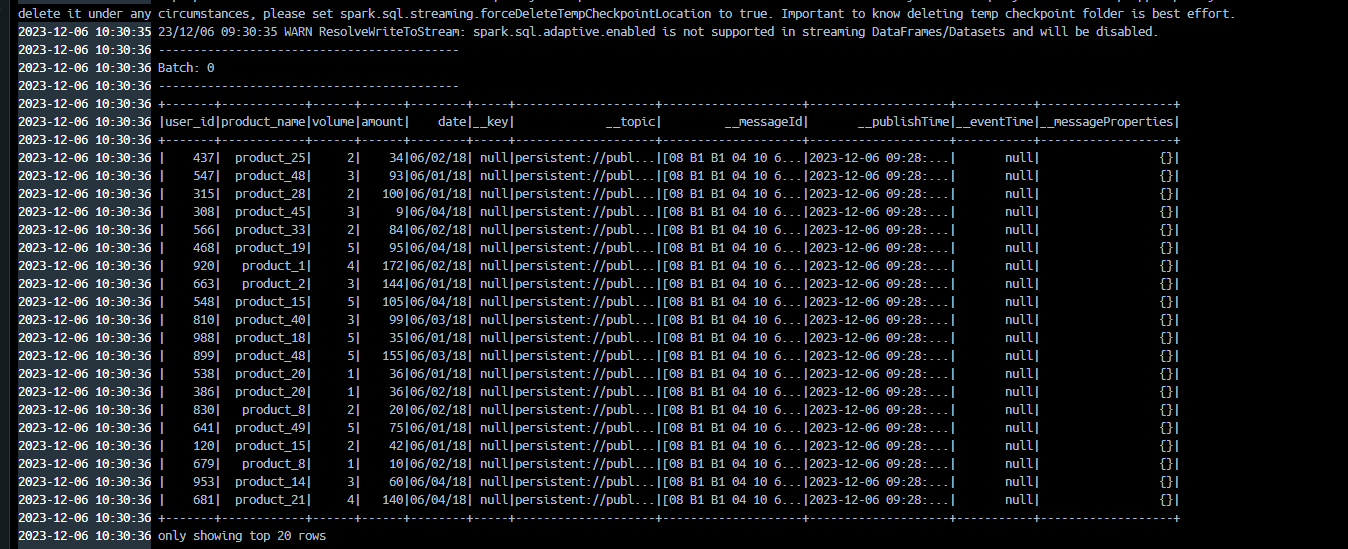

### data to enrich the stream with user localization

In [19]:
users_df = spark.read.load('s3a://stream-buck/users')

In [20]:
users_df.show(5)

+-------+----------------+
|user_id|    localization|
+-------+----------------+
|    930|localization_199|
|    931|localization_164|
|    932|localization_153|
|    933|localization_172|
|    934|localization_159|
+-------+----------------+
only showing top 5 rows



In [21]:
pulsar_income_df = pulsar_income_df.join(users_df, ['user_id'], 'left')
pulsar_income_df = pulsar_income_df.filter(f.col('amount') < 50 )   #filtering the data to only get transactions with amount lower than 50

In [22]:
console_stream = pulsar_income_df.writeStream.format("console").start()

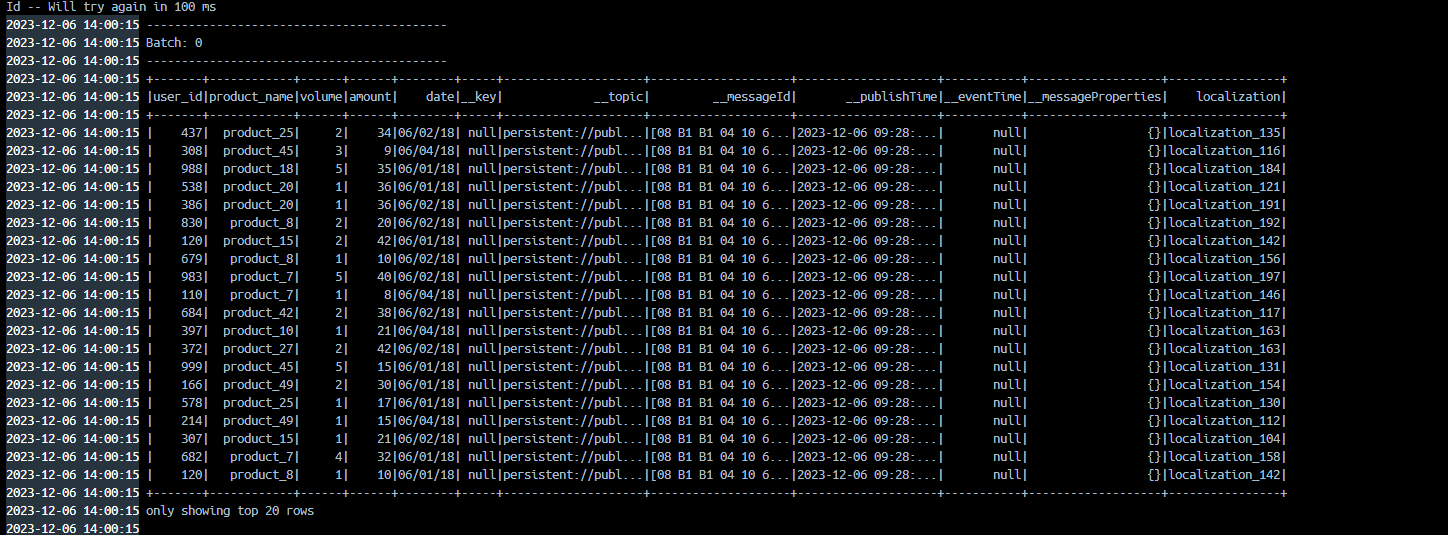

In [23]:
console_stream.stop()
pulsar_income_df.printSchema()

root
 |-- user_id: long (nullable = true)
 |-- product_name: string (nullable = true)
 |-- volume: long (nullable = true)
 |-- amount: long (nullable = true)
 |-- date: string (nullable = true)
 |-- __key: binary (nullable = true)
 |-- __topic: string (nullable = true)
 |-- __messageId: binary (nullable = true)
 |-- __publishTime: timestamp (nullable = true)
 |-- __eventTime: timestamp (nullable = true)
 |-- __messageProperties: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)
 |-- localization: string (nullable = true)



In [24]:
counting = pulsar_income_df.groupby(
    f.window(f.col('__publishTime'), "10 seconds","5 seconds"),
    f.col('localization')
)

In [25]:
counting = counting.agg(
    # f.first('user_id').alias('user_id'), 
    f.sum('volume').alias('products_count'),
    f.sum('amount').alias('amount_sum'), 
)

In [26]:
console_stream = counting.writeStream.format("console").outputMode('update').start()

In [27]:
counting.printSchema()

root
 |-- window: struct (nullable = true)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- localization: string (nullable = true)
 |-- products_count: long (nullable = true)
 |-- amount_sum: long (nullable = true)



aggreagated data by localization, showing total sum of transactions with total count of products sold, for transacrions where invidual transaction amount was less than 50

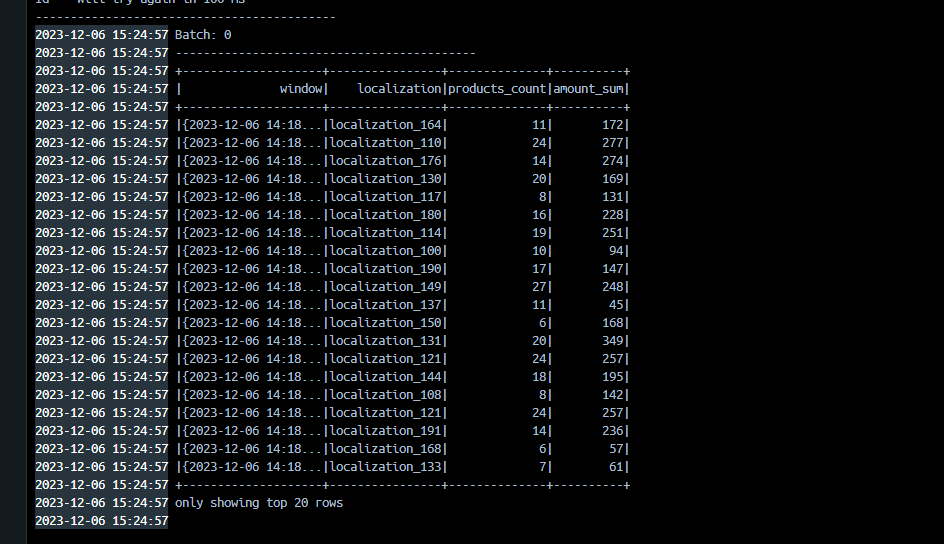

### saving data to minio

In [28]:
df_counter_writer = counting.writeStream \
   .format("delta") \
   .outputMode("complete") \
   .option("checkpointLocation", "./checkpoints-counting") \
   .start("s3a://stream-buck/new/")
df_counter_writer.status

{'message': 'Initializing sources',
 'isDataAvailable': False,
 'isTriggerActive': False}

In [29]:
df_counter_writer.status

{'message': 'Processing new data',
 'isDataAvailable': True,
 'isTriggerActive': True}

In [31]:
df_counter_writer.status

{'message': 'Waiting for data to arrive',
 'isDataAvailable': False,
 'isTriggerActive': False}

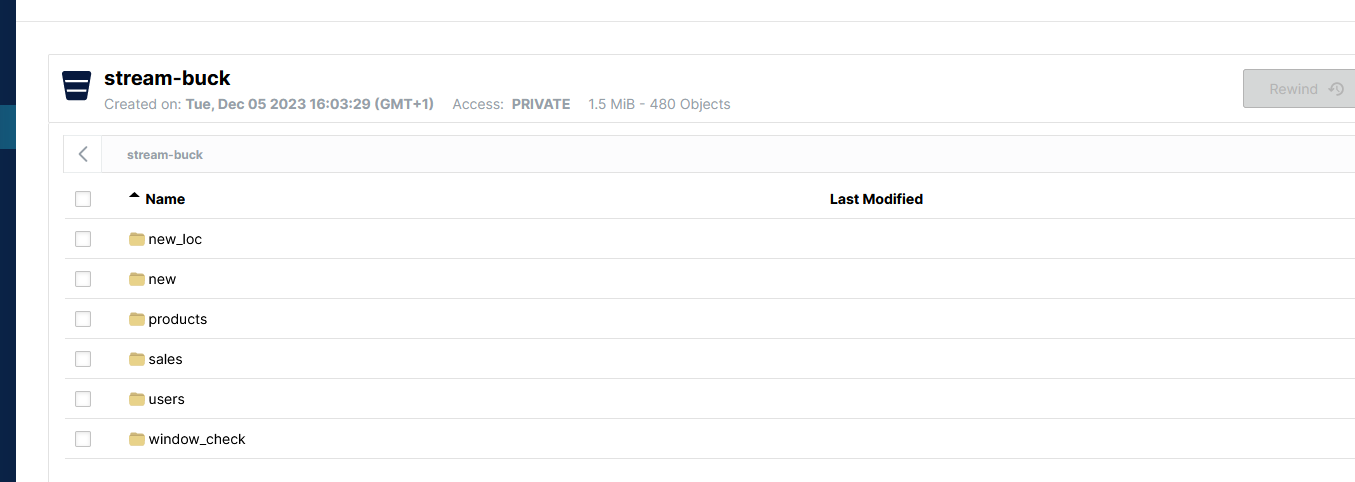

In [32]:
result = spark.read.format("delta").load("s3a://stream-buck/new/")
# result.filter(f.col('localization') == 'localization_117' ).show(1_000, truncate=False)

In [33]:
result.show(1000, truncate=False)

+------------------------------------------+----------------+--------------+----------+
|window                                    |localization    |products_count|amount_sum|
+------------------------------------------+----------------+--------------+----------+
|{2023-12-06 14:26:55, 2023-12-06 14:27:05}|localization_130|27            |206       |
|{2023-12-06 14:26:55, 2023-12-06 14:27:05}|localization_184|8             |73        |
|{2023-12-06 14:26:55, 2023-12-06 14:27:05}|localization_164|8             |135       |
|{2023-12-06 14:26:55, 2023-12-06 14:27:05}|localization_129|19            |165       |
|{2023-12-06 14:26:50, 2023-12-06 14:27:00}|localization_151|7             |108       |
|{2023-12-06 14:26:50, 2023-12-06 14:27:00}|localization_181|7             |108       |
|{2023-12-06 14:26:50, 2023-12-06 14:27:00}|localization_142|9             |112       |
|{2023-12-06 14:26:55, 2023-12-06 14:27:05}|localization_142|9             |112       |
|{2023-12-06 14:26:55, 2023-12-0